In [1]:
import pandas as pd
import numpy as np
from xray_stats import load_process as lp

## Basic XRay Data Overview
**Summary:** This Jupyter notebook provides an introductory analysis of x-rayed soil images, focusing on understanding basic statistics at different depths.

### The soil data set
The scanned soils cores that were analyzed for this project are from a long-term experiment at the North Agronomy Farm of Kansas State University in Manhattan, KS. For more info on data from that experiment:

Nicoloso, Rodrigo S., et al. "Carbon saturation and translocation in a no-till soil under organic amendments." Agriculture, Ecosystems & Environment 264 (2018): 73-84.

The soils are divided into two different practices each of tillage (chisel till - T, and no till - NT) and fertilizer (high fertilizer - HF, and high manure - HM). Native Prairie (NP) soil that is undisturbed by agricultural practice was also sampled. There are 54 scans in total used for this analysis. See below for treatment meta data. **Within this project structure, all loadable data except for the xray scans themselves are located under ../data/.**

In [2]:
metas = pd.read_csv("../data/meta.csv")
tillage_fert_counts = metas.groupby(['Tillage', 'Fertilizer']).size().reset_index(name='Count')

# Print totals
print(tillage_fert_counts)
# Showing first 5 scans
print(metas.head())
# Uncomment to see all metadata
# metas

  Tillage Fertilizer  Count
0      NP         NP      6
1      NT         HF     12
2      NT         HM     12
3       T         HF     12
4       T         HM     12
   Sample ID Tillage Fertilizer  Block  Sub-rep
0          1      NP         NP      1        1
1          2      NP         NP      2        1
2          3      NP         NP      3        1
3          4      NP         NP      4        1
4          5      NP         NP      5        1


### Soil X-Ray Image Data Structure
Each 3D x-ray scan has a folder with an image (tiff format) for each horizontal slice of the soil core. The location of all these files is by default set to **path_to_tiff_folders="/Volumes/FreeAgent GoFlex Drive/DanforthXRAYData/"** in the xray_stats/load_process library. *IMPORTANT: Make sure change this to the correct location of the xray data by editing get_tiff_stack in load_process.py prior to installing the library.* The structure looks as follows:

- path_to_tiff_folders/
    - Scan_Number1_39um/
        - Im_0000.tif
        - Im_0001.tif
        - Im_0002.tif
        - ...
    - Scan_Number2_39um/
        - Im_0000.tif
        - ...
    - ...

The folder and file naming convention is important to how the library parses and indexes the scans and tiff files. **For soil scan folders**, make sure the folder name is divided by underscores. The library takes the second to last underscore-seperated section and gets the number to assign the index. For example: 20210501Sbz_VBCSoilCores7_39um, its scan (or stack for tiff stack) index will be 7. **For file names**, it will use the last four digits before the extension for the image file's index. For example: 20210501_VBCsoilcore_7_39um 3_0002.tif will have an index of 2. Useful for ordering and assigning depth.

**Accessing the data:** The load_process library has many functions to access the xray scans, process statistics and visualize. This code assumes the xray data is located on a locally accessible directory (if the files need to be accessed remotely through ftp, sftp or other such protocol, significant modifications to the code are required). Let's take a look.

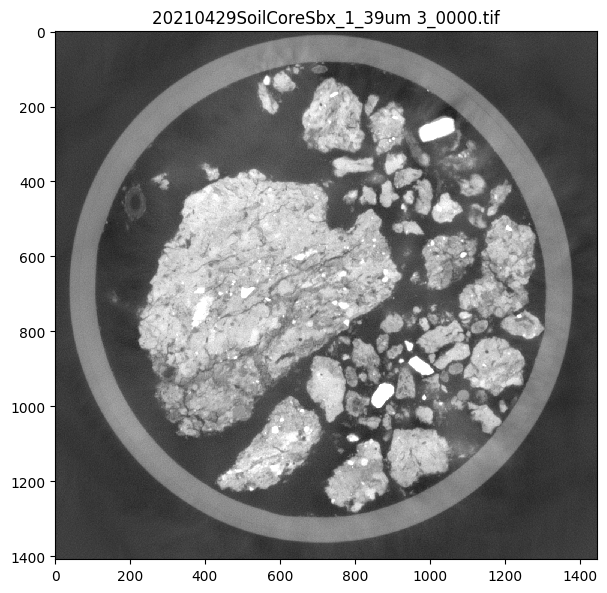

In [3]:
## Manually load and show a horizontal xray image slice
stack_index = 1 # This xray scan index is between 1 and 54 corresponding to "Sample ID" in the meta.csv.
total_images, tiff_files_sorted, path_to_tiff_stack = lp.get_tiff_stack(stack_index)

# Uncomment below to display the output
# print([total_images, tiff_files_sorted, path_to_tiff_stack])

# Load the image using PIL and display
import matplotlib.pyplot as plt
import os
from PIL import Image

filename = tiff_files_sorted[0] # get first (most shallow) image
img = Image.open(os.path.join(path_to_tiff_stack, filename))
img_array = np.array(img)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_array, cmap='gray',vmin=0, vmax=12000)
ax.set_title(filename)
plt.show()

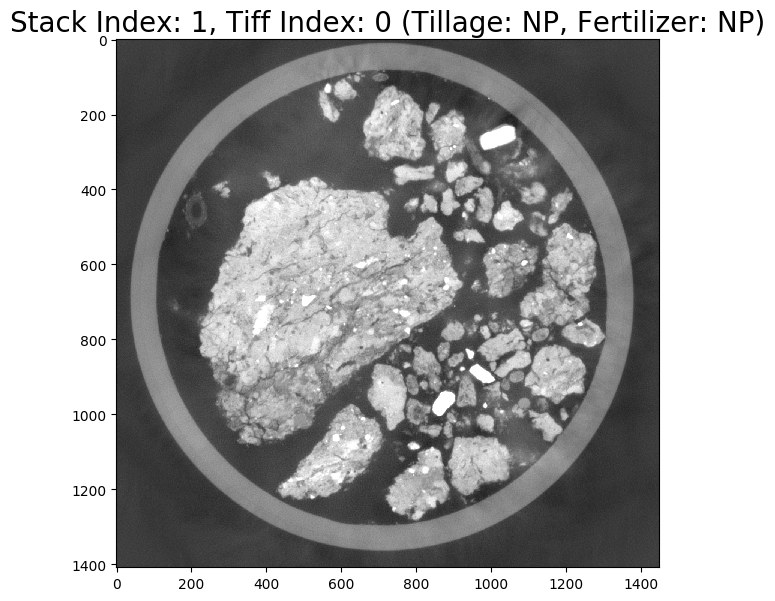

In [4]:
## Use load_process library instead to easily load and display the image
stack_index = 1 # This xray scan index is between 1 and 54 corresponding to "Sample ID" in the meta.csv.
tiff_index = 0 # index of horizontal tiff slice.
img_array = lp.display_horizontal_xray_slice(tiff_index, stack_index, max_intensity=12000)

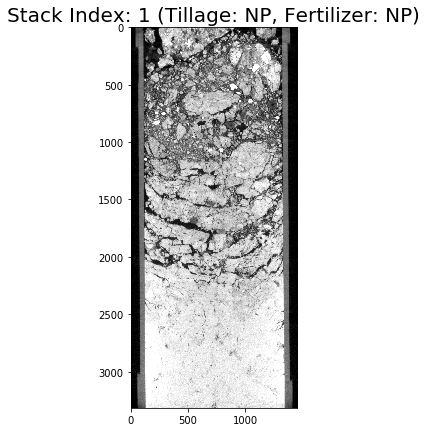

In [7]:
## Vertical Slice: show how much the soil changes by depth - this function will take a row of pixels
## from each horizontal tiff slice of a scan to make a vertical slice.
stack_index = 1 # Check metas and try scans with soils of different tillage/fertilizer treatments
target_row = 700 # Horizontal row of pixels to use for vertical slice.
img_array_vertical = lp.display_vertical_xray_slice(stack_index, target_row)

### Generating basic per-depth statistics
**Identifying soil regions:** If you experimented with horizontal and vertical slices from soils of different treatments, you will have noticed visual differences by depth. To begin to quantify these differences, we will measure some basic statistics of the x-rays by depth, such as **average, std and distribution of intensity values** by horizontal slice. But first, it's important to identify portions of the image that are part of the **soil core, container and outside air**. The load_process library does this for statistical calculations. Here's an example illustrating how it seperates the different sections.


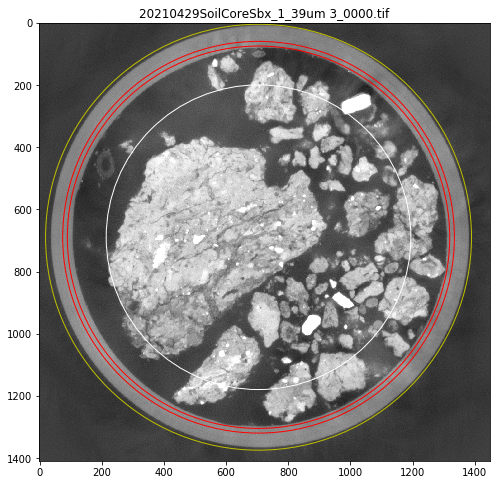

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import os
# Create the figure and axis objects for the plot
fig, ax = plt.subplots(figsize=(7, 7))
stack_index = 1
horizontal_slice_index = 0  # get first (most shallow) image
total_images, tiff_files_sorted, path_to_tiff_stack = lp.get_tiff_stack(stack_index)
filename = tiff_files_sorted[horizontal_slice_index] # get first (most shallow) image
# Load the image using PIL
img = Image.open(os.path.join(path_to_tiff_stack, filename))
# Convert the image to a numpy array
img_array = np.array(img)
# Identify the soil cores center.
xc, yc, r = lp.estimate_circle_from_image_pre(img_array)

# Update the plot with the new image and title
ax.imshow(img_array, cmap='gray',vmin=0, vmax=12000)
ax.set_title(filename)
circle = plt.Circle((xc, yc), 490, color='w', fill=False, label='Inner Soil')
ax.add_artist(circle)

circle = plt.Circle((xc, yc), 615, color='r', fill=False, label='Plastic Ring Inside')
ax.add_artist(circle)

circle = plt.Circle((xc, yc), 630, color='r', fill=False, label='Plastic Ring Outside')
ax.add_artist(circle)

circle = plt.Circle((xc, yc), 685, color='y', fill=False, label='Outside Area')
ax.add_artist(circle)

fig.tight_layout()
plt.show()

The radii of different regions are manually chosen in units of pixels assuming a constant diameter for the container walls (and the same spatial pixel resolution across all scans: 39 um). However, the diameter of the container can vary with depth, causing the occasional inclusion of some non-container pixels in the **container region (region between the red circles)** and container pixels in the **outside air region (region outside the yellow circle)**. But the thin region chosen for the container represents an area that largly remains a part of the container at all depths. The **soil core region (inside the white circle)** leaves some buffer from the walls of the container to reduce potential edge effects.

**Pixel intensity distributions for different soil regions:** With this functionality, we can analyze the distributions of pixel intensities for each region and depth of a soil x-ray sample:


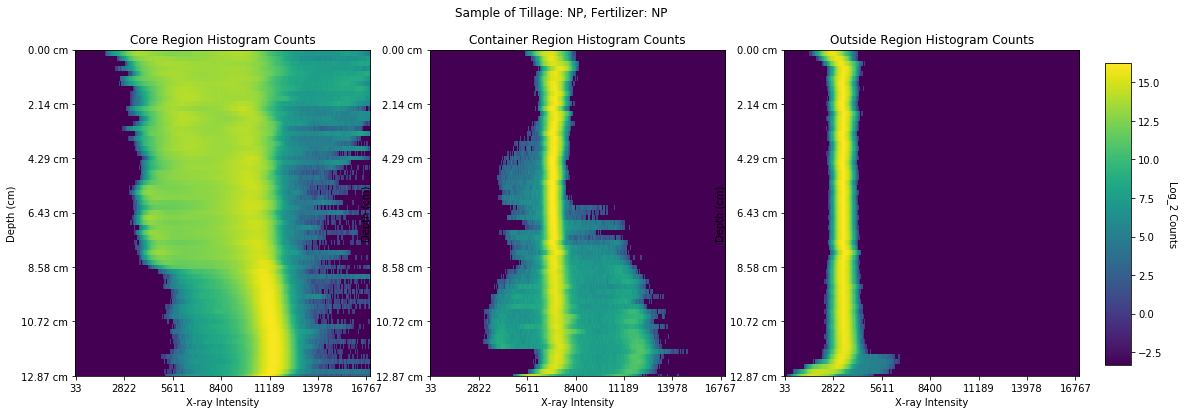

In [6]:
stack_index = 1
skip_value = 50 # how many slices to skip, useful to speed up calculations for quick inspections
basic_stats_by_depth = lp.intensity_histogram_by_depth(stack_index, skip_value)

**Basic pixel intensity statistics soil regions:** Additionally, we can generate basic statistics of the pixel intensity distributions for each of the three regions with in an image. Here is an example for a single horizontal X-Ray slice:

In [13]:
stack_index = 1
horizontal_slice_index = 0  # get first (most shallow) image

total_images, tiff_files_sorted, path_to_tiff_stack = lp.get_tiff_stack(stack_index)
horizontal_slice_filename = tiff_files_sorted[horizontal_slice_index]

## Get stats for single horizontal slice
result = lp.get_intensity_stats(path_to_tiff_stack, horizontal_slice_filename)
print(f"Intensity Statistics for Stack {stack_index}, Slice {horizontal_slice_index} ("+lp.get_treatment(stack_index)+ "):")
print("1st Percentile Core:", result[0])
print("50th Percentile Core:", result[1])
print("99th Percentile Core:", result[2])
print("Mean Core:", result[3])
print("Standard Deviation Core:", result[4])
print("1st Percentile Container:", result[5])
print("50th Percentile Container:", result[6])
print("99th Percentile Container:", result[7])
print("Mean Container:", result[8])
print("Standard Deviation Container:", result[9])
print("1st Percentile Outside:", result[10])
print("50th Percentile Outside:", result[11])
print("99th Percentile Outside:", result[12])
print("Mean Outside:", result[13])
print("Standard Deviation Outside:", result[14])

Intensity Statistics for Stack 1, Slice 0 (Tillage: NP, Fertilizer: NP):
1st Percentile Core: 2680.0
50th Percentile Core: 7570.0
99th Percentile Core: 13223.0
Mean Core: 7090.208260584246
Standard Deviation Core: 2846.987519078827
1st Percentile Container: 5574.0
50th Percentile Container: 6550.0
99th Percentile Container: 7469.0
Mean Container: 6536.864711899079
Standard Deviation Container: 409.56341183206024
1st Percentile Outside: 2159.0
50th Percentile Outside: 2707.0
99th Percentile Outside: 3233.0
Mean Outside: 2705.841398075468
Standard Deviation Outside: 232.47292713153908


**Pixel intensity stats by depth, compare different soil treatments:** These calculations can be performed at multiple depths and plotted as below. Let's take a look at samples from different soil treatments.

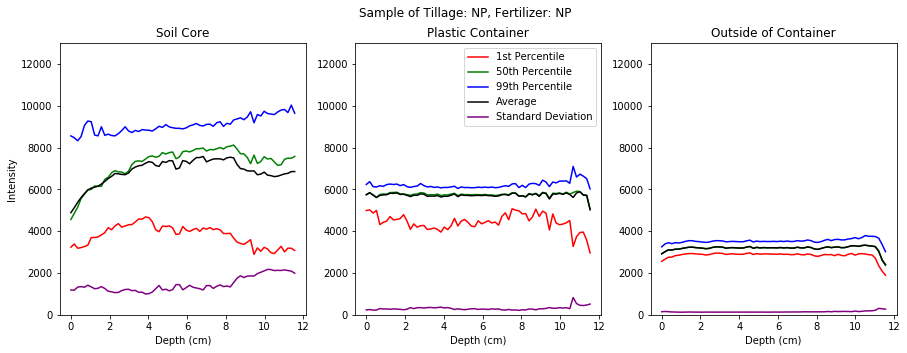

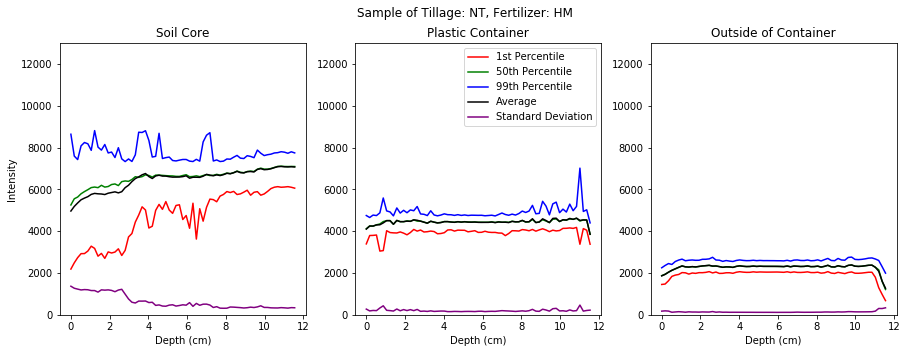

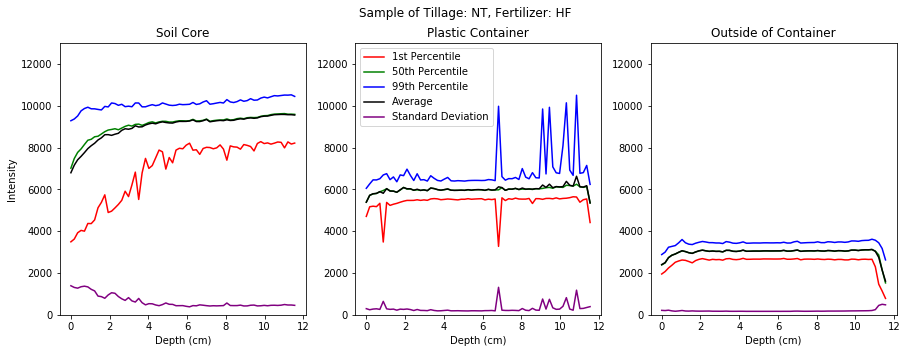

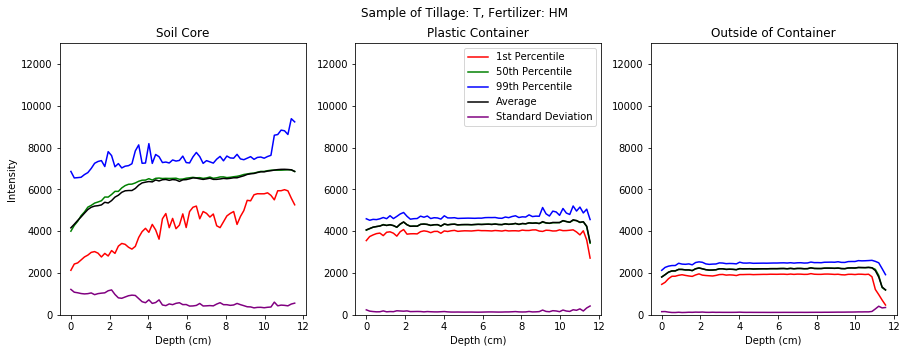

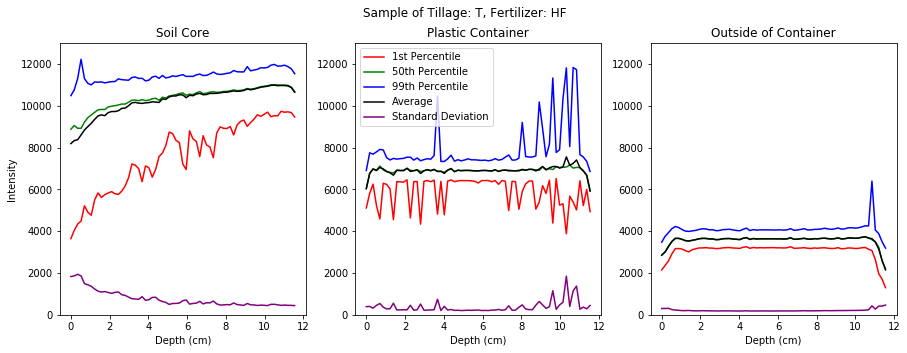

In [10]:
skip_value = 50 # how many slices to skip, useful to speed up for quick inspections

# Sample Native Prairie
stack_index = 6
basic_stats_by_depth = lp.plot_intensity_stats_by_depth(stack_index, skip_value)

# Sample No Till, High Manure
stack_index = 18
basic_stats_by_depth = lp.plot_intensity_stats_by_depth(stack_index, skip_value)

# Sample No Till, High Fertilizer
stack_index = 29
basic_stats_by_depth = lp.plot_intensity_stats_by_depth(stack_index, skip_value)

# Sample Till, High Manure
stack_index = 42
basic_stats_by_depth = lp.plot_intensity_stats_by_depth(stack_index, skip_value)

# Sample Till, High Fertilizer
stack_index = 52
basic_stats_by_depth = lp.plot_intensity_stats_by_depth(stack_index, skip_value)


The density of xray imaged material is proportional to the amount xray attenuation that passes through, where higher attenuation (or brighter pixel intensity) means greater material density. However, to accurately measure density, it's necessary to use regions of known density (like the plastic container, ~1.022 g/ml, and outside air, ~0) to normalize the soil pixels.

Some variation in the tails of the container and outside distributions exist due to occasional misidentification of those two regions. While more advanced container segmentation techniques can remedy this, the median and mean remain consistant across most regions/depths, thus we use these values (specifically average intensities) to normalize the soil pixels. This is important to compare soil densities of different scans and soil treatments, given that each scan may have different settings during x-ray capture.

We normalize as follows:

$$
\rho = \frac{I - I_{\text{outside air}}}{I_{\text{container}} - I_{\text{outside air}}} \times \rho_{\text{container}}
$$

Where:
- $\rho$ is the density.
- $I$ is the intensity of a pixel in the soil core region.
- $I_{\text{outside air}}$ is the average intensity of the outside air.
- $I_{\text{container}}$ is the average intensity of the container.
- $\rho_{\text{container}}$ is the density of the container (1.022 g/ml).

See below for container-normalized calculations of density.

In [ ]:
skip_value = 50 # how many slices to skip, useful to speed up for quick inspections

# Sample Native Prairie
stack_index = 6
basic_stats_by_depth = lp.plot_soil_density_stats_by_depth(stack_index, skip_value)

## Uncomment below to compare against other soil treatments
# # Sample No Till, High Manure
# stack_index = 18
# basic_stats_by_depth = lp.plot_soil_density_stats_by_depth(stack_index, skip_value)

# # Sample No Till, High Fertilizer
# stack_index = 29
# basic_stats_by_depth = lp.plot_soil_density_stats_by_depth(stack_index, skip_value)

# # Sample Till, High Manure
# stack_index = 42
# basic_stats_by_depth = lp.plot_soil_density_stats_by_depth(stack_index, skip_value)

# # Sample Till, High Fertilizer
# stack_index = 52
# basic_stats_by_depth = lp.plot_soil_density_stats_by_depth(stack_index, skip_value)

### Takeaways:
These calculations will be used as we analyze and compare all data sets and generate per treatment statistics of soil density. However, **this calibration technique still needs to be validated against soil bulk density measurements on new soil samples and scans (as soil bulk density measurements do not exist for these 54 data sets) to ensure accurate measurement of density.** Some historical numbers from this experimental field exist below:

- **Parker, Nathaniel, et al.** *A database of soil physical properties for the Kansas Mesonet.* Soil Science Society of America Journal 86.6 (2022): 1495-1508.
- **Mikha, Maysoon M., and Charles W. Rice.** *Tillage and manure effects on soil and aggregate‐associated carbon and nitrogen.* Soil Science Society of America Journal 68.3 (2004): 809-816.

In 1990, both no till and chisel disk till had bulk densities of 1.18 (g/cm³) within a depth range 0-5 cm. By 1999, these values had shifted slightly to 1.5 g/cm³ for no-till and 1.4 g/cm³ for till, still within the same depth range. Using the xray measurements at that depth calibrating against the plastic container, we get around 1.6 for high manure and 1.9 for high fertilizer - not much difference between till and no till. These figures did not perfectly align with the published data, although they were in close proximity. 

Deeper than that (5 cm - 12 cm) the xray densities get quite high (around 2), which raises questions. The mesonet data for Kansas State North Agronomy Farm site has values between 1.3 and 1.5 from nominal depths of 5 to 50 cm.

Several factors could affect the accuracy of these measurements: densities could have increased over the past 20 years. One difference between soil bulk density measurements and xray samples is that the xray samples are not oven dried. So the density of the water may be affecting the average measurement of density. While this suggests xray density calculations may be valid, comparing against ground truth bulk density measurements is important.

### Next:
While capturing local differences in calibrated soil density measurments seems feasible (though with some required validation), it is still possible to capture aspects of the soil heterogeneity that are less sensitive to these absolute value density scalings using alternative local statistical technqiues. We will explore these techniques in the next notebook.